Donkey Car Tainer V5
----------------------------

## Avant propos


#### Lister les GPU disponibles

In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())


2021-08-25 14:27:29.150544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-25 14:27:29.178923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 14:27:29.208544: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.2/bin:/opt/maven/bin:/home/nigiva/.local/bin:/opt/maven/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/s

In [2]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

[]
2021-08-25 14:27:29.318744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 14:27:29.319083: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


#### Choisir le GPU de lancement

- Avec la variable d'environnement `CUDA_VISIBLE_DEVICES`, asigner la valeur :
  * `-1` pour faire du calcul sur CPU
  * `0` ou `1` ou ... pour faire du calcul respectivement sur GPU 0, 1 ou ...
  * `0,1` pour faire du calcul sur les 2 GPU 0 et GPU 1.

- Si `CUDA_VISIBLE_DEVICES` ne fonctionne pas,
on peut encadrer le fit avec ce code :
```
with tf.device("/gpu:1"):
    model.fit(...)
```
pour lancer sur le GPU 1.

In [3]:
import os
TRAIN_GPU = "/gpu:0"
CUDA_VISIBLE_DEVICES = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_VISIBLE_DEVICES

## Importer les librairies

In [4]:
import os
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm
import json
from PIL import Image
import base64
from io import BytesIO
import inspect
from matplotlib import pyplot as plt
import datetime
from loguru import logger
import shutil

In [5]:
from dctrainer.utils.utils import build_log_tag
from dctrainer.dataset.extractor import ESLRExtractor
from dctrainer.dataset.augmentator import DonkeyCarDataAugmentator
from dctrainer.utils.inspector import load_source, save_source
from dctrainer.model.model_wrapper import DCModelWrapper

## Importer la dataset

### Depuis Colab via Google Drive

```python
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
```
Et puis :
```
!rm -Rf "corentin_renault_20000_record_controller"
!cp "drive/My Drive/ColabStorage/DonkeyCar/Simulator/Dataset/corentin_renault_20000_record_controller.eslr" "dataset.eslr"
```

### Autre source via CURL

```
!curl <LIEN_URL> --output dataset.eslr
```

## Configuration

In [7]:
TIME = str(time())

### Environement

In [8]:
### ENVIRONEMENT ###
STORAGE_ROOT_DIR = os.path.abspath("../../../data")
STORAGE_ROOT_DIR

'/home/nigiva/git/donkey-car-trainer/data'

### Modèle

In [9]:
### MODEL ###
MODEL_NAME = "DCDeepModelV5.0-reda-renault-speed_accel_gyro-" + TIME
os.environ["MODEL_NAME"] = MODEL_NAME
os.environ["MODEL_NAME_TAR"] = MODEL_NAME+".tar.gz"

### Sauvegarde

In [10]:
### SAVE PATH ###
SAVE_PATH = os.path.join(STORAGE_ROOT_DIR, "model", MODEL_NAME)
os.environ["SAVE_PATH"] = SAVE_PATH
os.makedirs(SAVE_PATH, exist_ok=True)

# Don't remove the last "s" in "checkpoints",
# the file `checkpoint` already exists
CHECKPOINT_PATH = os.path.join(SAVE_PATH, "checkpoints")
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
CHECKPOINT_FILEPATH = os.path.join(CHECKPOINT_PATH, "checkpoint-{epoch:02d}.weight")

### Log d'entraînement

In [11]:
### LOG ###
ROOT_TENSORLOG_PATH = os.path.join(STORAGE_ROOT_DIR, "log", MODEL_NAME)
os.makedirs(ROOT_TENSORLOG_PATH, exist_ok=True)
logger.add(os.path.join(ROOT_TENSORLOG_PATH, "notebook.log"), level="DEBUG")

1

In [12]:
def get_new_tensorlog_path():
    special_log_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    special_log_path = os.path.join(ROOT_TENSORLOG_PATH, special_log_name)
    os.makedirs(special_log_path)
    logger.info(build_log_tag(LOG_PATH=special_log_path))
    os.environ["LOG_PATH"] = special_log_path
    return special_log_path

### Dataset

In [16]:
### DATASET ###
DATASET_NAME = "corentin_renault_30000_clean_record_controller"
DATASET_STORE_PATH = os.path.join(STORAGE_ROOT_DIR, "sample")
DATASET_FILE_PATH = os.path.join(DATASET_STORE_PATH, DATASET_NAME + ".eslr")

IMAGE_PATH = "images"
DATASET_LABEL_FILENAME = "label.csv"

DATASET_LABEL_PATH = os.path.join(DATASET_STORE_PATH, DATASET_NAME, DATASET_LABEL_FILENAME)
DATASET_IMAGE_PATH = os.path.join(DATASET_STORE_PATH, DATASET_NAME, IMAGE_PATH)

In [17]:
BATCH_SIZE = 32
SPLIT_VALIDATION = 0.05
SPLIT_TEST = 0.05
NUM_PARALLEL_CALLS = 3
APPLY_DATA_AUGMENTATION = True
PREFRECH = 2

### Entrée du réseau

In [18]:
IMAGE_SHAPE = (120,160, 3)

### Résumé

In [19]:
logger.info(build_log_tag(TIME=TIME))
logger.info(build_log_tag(STORAGE_ROOT_DIR=STORAGE_ROOT_DIR))
logger.info(build_log_tag(MODEL_NAME=MODEL_NAME))
logger.info(build_log_tag(SAVE_PATH=SAVE_PATH))
logger.info(build_log_tag(CHECKPOINT_PATH=CHECKPOINT_PATH))
logger.info(build_log_tag(CHECKPOINT_FILEPATH=CHECKPOINT_FILEPATH))
logger.info(build_log_tag(ROOT_TENSORLOG_PATH=ROOT_TENSORLOG_PATH))
logger.info(build_log_tag(DATASET_NAME=DATASET_NAME))
logger.info(build_log_tag(DATASET_FILE_PATH=DATASET_FILE_PATH))
logger.info(build_log_tag(IMAGE_PATH=IMAGE_PATH))
logger.info(build_log_tag(DATASET_STORE_PATH=DATASET_STORE_PATH))
logger.info(build_log_tag(DATASET_LABEL_FILENAME=DATASET_LABEL_FILENAME))
logger.info(build_log_tag(DATASET_LABEL_PATH=DATASET_LABEL_PATH))
logger.info(build_log_tag(DATASET_IMAGE_PATH=DATASET_IMAGE_PATH))
logger.info(build_log_tag(CUDA_VISIBLE_DEVICES=CUDA_VISIBLE_DEVICES))
logger.info(build_log_tag(TRAIN_GPU=TRAIN_GPU))
logger.info(build_log_tag(BATCH_SIZE=BATCH_SIZE))
logger.info(build_log_tag(SPLIT_VALIDATION=SPLIT_VALIDATION))
logger.info(build_log_tag(SPLIT_TEST=SPLIT_TEST))
logger.info(build_log_tag(NUM_PARALLEL_CALLS=NUM_PARALLEL_CALLS))
logger.info(build_log_tag(APPLY_DATA_AUGMENTATION=APPLY_DATA_AUGMENTATION))
logger.info(build_log_tag(PREFRECH=PREFRECH))
logger.info(build_log_tag(IMAGE_SHAPE=IMAGE_SHAPE))

2021-08-25 14:28:06.477 | INFO     | __main__:<module>:1 - [TIME="1629894462.0771937"]
2021-08-25 14:28:06.479 | INFO     | __main__:<module>:2 - [STORAGE_ROOT_DIR="/home/nigiva/git/donkey-car-trainer/data"]
2021-08-25 14:28:06.483 | INFO     | __main__:<module>:3 - [MODEL_NAME="DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629894462.0771937"]
2021-08-25 14:28:06.484 | INFO     | __main__:<module>:4 - [SAVE_PATH="/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629894462.0771937"]
2021-08-25 14:28:06.488 | INFO     | __main__:<module>:5 - [CHECKPOINT_PATH="/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629894462.0771937/checkpoints"]
2021-08-25 14:28:06.492 | INFO     | __main__:<module>:6 - [CHECKPOINT_FILEPATH="/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629894462.0771937/checkpoints/checkpoint-{epoch:02d}.weight"]
2021-08-25 14:28:06.494 | IN

## Extraire la dataset

On convertit chaque ligne du fichier *.eslr envoyées par le serveur en :
- une image qui sera stockée dans le dossier `<DATASET_NAME>/<DATASET_IMAGE_PATH>`
- une ligne dans le csv label.csv avec toutes les infos (reliées à aux images par leur `path`)

In [20]:
eslr_extractor = ESLRExtractor(DATASET_FILE_PATH)
eslr_extractor.extract(label_path = DATASET_LABEL_PATH, images_path = DATASET_IMAGE_PATH)
raw_data = eslr_extractor.read_csv(DATASET_LABEL_PATH)

2021-08-25 14:28:14.207 | INFO     | dctrainer.dataset.extractor:extract:19 - .eslr is already extracted !


array([[<AxesSubplot:title={'center':'steering_angle'}>,
        <AxesSubplot:title={'center':'throttle'}>,
        <AxesSubplot:title={'center':'speed'}>,
        <AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'accel_x'}>],
       [<AxesSubplot:title={'center':'accel_y'}>,
        <AxesSubplot:title={'center':'accel_z'}>,
        <AxesSubplot:title={'center':'gyro_x'}>,
        <AxesSubplot:title={'center':'gyro_y'}>,
        <AxesSubplot:title={'center':'gyro_z'}>],
       [<AxesSubplot:title={'center':'gyro_w'}>,
        <AxesSubplot:title={'center':'pos_x'}>,
        <AxesSubplot:title={'center':'pos_y'}>,
        <AxesSubplot:title={'center':'pos_z'}>,
        <AxesSubplot:title={'center':'vel_x'}>],
       [<AxesSubplot:title={'center':'vel_y'}>,
        <AxesSubplot:title={'center':'vel_z'}>,
        <AxesSubplot:title={'center':'cte'}>,
        <AxesSubplot:title={'center':'activeNode'}>,
        <AxesSubplot:title={'center':'totalNodes'}>],
       

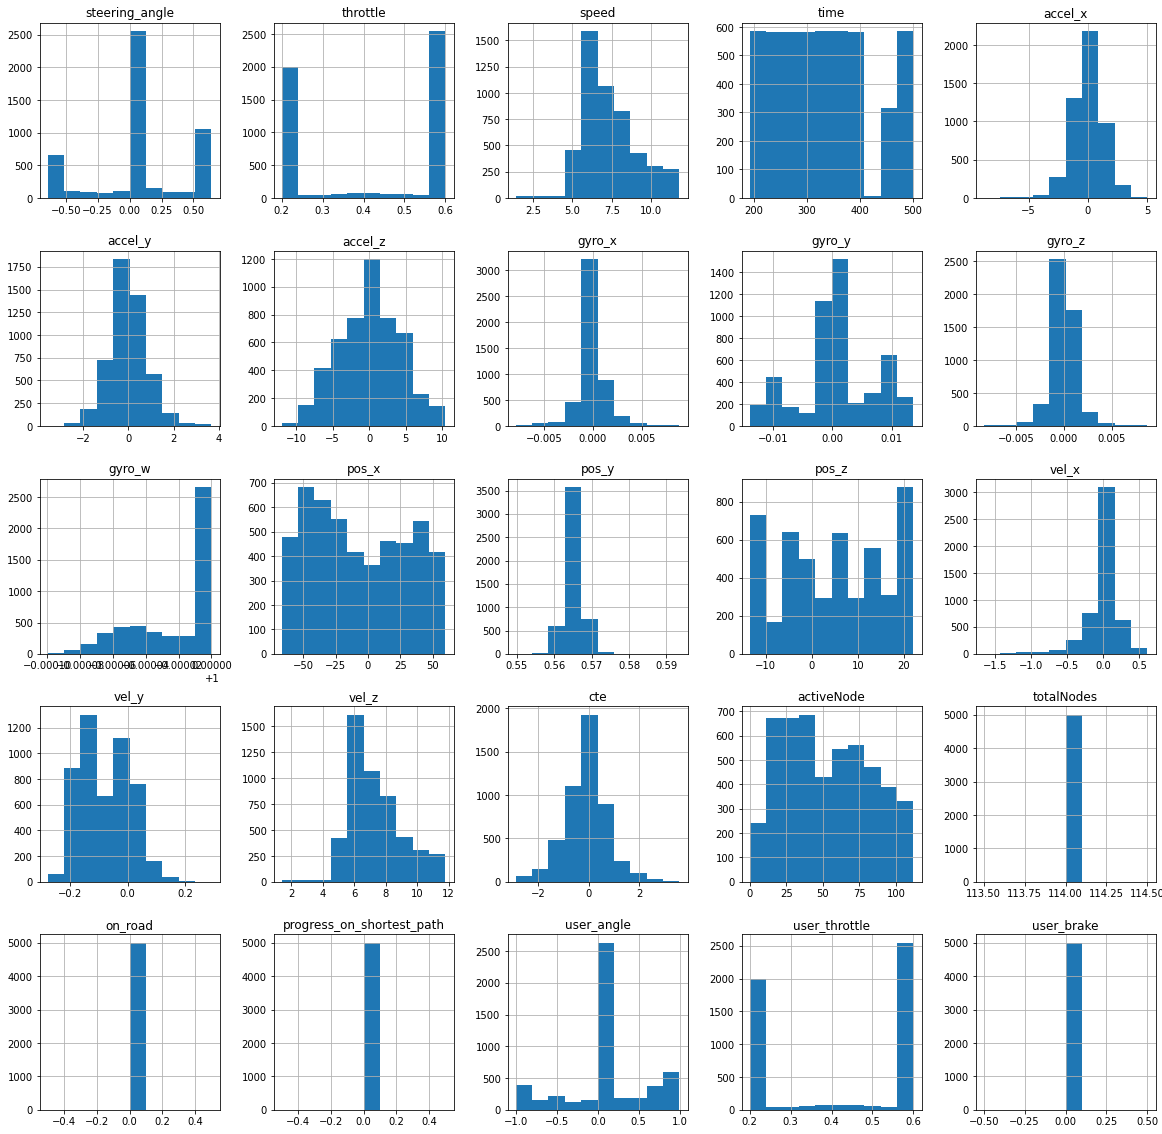

In [19]:
raw_data.hist(figsize=(20,20))

## Le modèle

### Chargement d'un modèle et d'un Wrapper déjà existant
Ça implique qu'il est inutile de "Créer le modèle" ou même inutile de "Créé le Wrapper".

In [26]:
# brain = DCModelWrapper.load("/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629812869.419665")

2021-08-25 14:34:14.432 | INFO     | dctrainer.model.model_wrapper:load:30 - [LOAD WRAPPER AND MODEL][path="/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629812869.419665"]


### Creation du modèle

In [42]:
class DCModel(keras.Model):
  def __init__(self, name="DCModel"):
    super(DCModel, self).__init__(name=name)
    self.cnn_1 = keras.layers.Conv2D(24, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu', name='image')
    self.bn_1 = tf.keras.layers.BatchNormalization()

    self.cnn_2 = keras.layers.Conv2D(36, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_2 = keras.layers.BatchNormalization()

    self.cnn_3 = keras.layers.Conv2D(48, (5, 5), strides=(2, 2), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_3 = keras.layers.BatchNormalization()

    self.cnn_4 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_4 = keras.layers.BatchNormalization()

    self.cnn_5 = keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer='he_uniform', activation='relu')
    self.bn_5 = keras.layers.BatchNormalization()

    self.drop_1 = keras.layers.Dropout(0.2)

    self.flat = keras.layers.Flatten()

    self.middle_input = keras.layers.Dense(7, name='speed_accel_gyro')
    self.bn_middle = keras.layers.BatchNormalization()
    self.merge = keras.layers.Concatenate()

    self.dense_1 = keras.layers.Dense(100, kernel_initializer='he_uniform', activation='elu')
    self.bn_6 = keras.layers.BatchNormalization()
    self.drop_2 = keras.layers.Dropout(0.1)

    self.dense_2 = keras.layers.Dense(50, kernel_initializer='he_uniform', activation='elu')
    self.bn_7 = keras.layers.BatchNormalization()
    self.drop_3 = keras.layers.Dropout(0.1)

    self.dense_3 = keras.layers.Dense(25, kernel_initializer='he_uniform', activation='elu')
    self.bn_8 = keras.layers.BatchNormalization()

    self.output_layer_1 = keras.layers.Dense(1, activation='linear', name='angle')
  
  @tf.function
  def call(self, inputs, training=False):
    l = self.cnn_1(inputs['image'])
    l = self.bn_1(l)
    
    l = self.cnn_2(l)
    l = self.bn_2(l)

    l = self.cnn_3(l)
    l = self.bn_3(l)

    l = self.cnn_4(l)
    l = self.bn_4(l)

    l = self.cnn_5(l)
    l = self.bn_5(l)

    l = self.drop_1(l)

    l = self.flat(l)

    m = self.middle_input(inputs['speed_accel_gyro'])
    m = self.bn_middle(m)

    l = self.merge([l, m])

    l = self.dense_1(l)
    l = self.bn_6(l)
    l = self.drop_2(l)

    l = self.dense_2(l)
    l = self.bn_7(l)
    l = self.drop_3(l)

    l = self.dense_3(l)
    l = self.bn_8(l)
    
    return {'angle' : self.output_layer_1(l)}

### Creation du wrapper

In [43]:
class Brain:
    def __init__(self, model=None):
        self.input_shape = {'image':['image'], 'speed_accel_gyro':['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}
        self.output_shape = {'angle':['user_angle']}

        self.model = model
        self.load_model_code_path = None
        self.load_wrapper_code_path = None

    def input_transformer(self, request):
        input_transformed = dict()

        # Convertir base64 en Image
        base64_img = request["image"]
        byte_string_img = base64.b64decode(base64_img)
        byte_img = BytesIO(byte_string_img)
        img = np.array(Image.open(byte_img)).astype(np.float32)

        # Construire l'entrée du modèle en respectant self.input_shape de l'entraînement
        img_expand = np.expand_dims(img, axis=0)
        input_transformed["image"] = np.expand_dims(img_expand, axis=0)

        speed_accel_gyro = [request[p] for p in self.input_shape['speed_accel_gyro']]
        speed_accel_gyro = np.array(speed_accel_gyro)
        speed_accel_gyro_expand = np.expand_dims(speed_accel_gyro, axis=0)
        input_transformed["speed_accel_gyro"] = np.expand_dims(speed_accel_gyro_expand, axis=0)

        return tf.data.Dataset.from_tensor_slices(input_transformed)

    def input_preprocessing(self, inputs_tensor, num_parallel_calls=1):
        def preprocessing_func(input_dict, *args):
            # Normalize image
            input_dict_copy = dict(input_dict)
            img = input_dict['image']
            normalized_img = (img / 127.5) - 1.0
            normalized_img = tf.reshape(normalized_img, img.shape)
            input_dict_copy['image'] = normalized_img
            return input_dict_copy, *args
        
        return inputs_tensor.map(preprocessing_func, num_parallel_calls = num_parallel_calls)

    def predict(self, request):
        input_tensor = self.input_transformer(request)
        preprocess_input = self.input_preprocessing(input_tensor)
        output = self.model.predict(preprocess_input)
        return self.output_transformer(output)

    def output_transformer(self, output):
        angle = output['angle'][0][0]
        angle_satured = 0.4 if abs(angle) > 0.4 else abs(angle)
        throttle = 0.6 - angle_satured
        return (angle, throttle, 0)

    @staticmethod
    def get_model_code_path(path):
        return os.path.join(path, "model.code")

    @staticmethod
    def get_wrapper_path(path):
        return os.path.join(path, "wrapper.code")
    
    @staticmethod
    def get_model_path(path):
        return os.path.join(path, "model.tf")

    @staticmethod
    def get_weights_path(path):
        return os.path.join(path, "weights.data")

    def save(self, path):
        # Créé le dossier de sauvegarde s'il n'existe pas encore
        os.makedirs(path, exist_ok=True)
        if self.load_model_code_path is not None and os.path.exists(self.load_model_code_path):
            shutil.copy(self.get_model_code_path(self.load_model_code_path), self.get_model_code_path(path))
        else:
            save_source(self.model.__class__, self.get_model_code_path(path))
        
        if self.load_wrapper_code_path is not None and os.path.exists(self.load_wrapper_code_path):
            shutil.copy(self.get_wrapper_path(self.load_wrapper_code_path), self.get_wrapper_path(path))
        else:
            save_source(self.__class__, self.get_wrapper_path(path))

        self.model.save(self.get_model_path(path), save_format='tf')

        # Par sécurité, on sauvegarde aussi les poids séparément
        self.model.save_weights(self.get_weights_path(path))

    def compile_model(self):
        optimizer = keras.optimizers.Adam(learning_rate=0.00035)
        self.model.compile(optimizer=optimizer,loss=keras.losses.MSE, metrics=["mse"])

    def load_model(self, model_path):
        # Load Saved Model
        # BUG when we want retrain the loaded model
        ## self.model = tf.keras.models.load_model(model_path)
        self.load_model_code_path = os.path.dirname(model_path)
        model_code_path = self.get_model_code_path(self.load_model_code_path)
        DCModelLoaded = load_source(model_code_path, class_name_to_load="DCModel")
        self.model = DCModelLoaded()
        self.model.load_weights(self.get_weights_path(self.load_model_code_path))
        self.compile_model()


### Instanciation du modèle et du wrapper

In [44]:
model = DCModel(name='DonkeyCarModel')
brain = Brain(model=model)
brain.compile_model()

2021-08-25 14:18:28.417247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 14:18:28.418749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Préparer la dataset

### Split en 3 jeux : Train, Test et Validation

In [45]:
train_and_test_set, validation_set = train_test_split(raw_data,
                                             test_size = SPLIT_VALIDATION,
                                             shuffle = True)
train_set, test_set = train_test_split(train_and_test_set,
                                             test_size = SPLIT_TEST,
                                             shuffle = True)

NBR_ROW_TRAIN_SET = train_set.shape[0]
NBR_ROW_TEST_SET = test_set.shape[0]
NBR_ROW_VALIDATION_SET = validation_set.shape[0]
logger.info(build_log_tag(NBR_ROW_TRAIN_SET=NBR_ROW_TRAIN_SET))
logger.info(build_log_tag(NBR_ROW_TEST_SET=NBR_ROW_TEST_SET))
logger.info(build_log_tag(NBR_ROW_VALIDATION_SET=NBR_ROW_VALIDATION_SET))

2021-08-25 14:18:33.050 | INFO     | __main__:<module>:11 - [NBR_ROW_TRAIN_SET="4512"]
2021-08-25 14:18:33.064 | INFO     | __main__:<module>:12 - [NBR_ROW_TEST_SET="238"]
2021-08-25 14:18:33.067 | INFO     | __main__:<module>:13 - [NBR_ROW_VALIDATION_SET="250"]


### Convertir DataFrame en tf.data.Dataset

In [46]:
def dataset_to_tensor(dataset, input_shape, output_shape):
    input_dict = {}
    output_dict = {}

    input_shape_with_path = dict(input_shape)
    input_shape_with_path['image'] = ['path']
    logger.info(build_log_tag("CONVERT DATASET TO TENSOR", input_shape=input_shape, input_shape_with_path=input_shape_with_path, output_shape=output_shape))

    for k, l in input_shape_with_path.items():
      if len(l) != 0:
        if len(l) == 1:
          # ['label'] ne donnera pas [['value1'], ...]
          # Mais plutôt ['value1', ...]
          input_dict[k] = dataset[l[0]]
        else:
          input_dict[k] = dataset[l]

    # Outputs
    for k, l in output_shape.items():
      if len(l) != 0:
        if len(l) == 1:
          # ['label'] ne donnera pas [['value1'], ...]
          # Mais plutôt ['value1', ...]
          output_dict[k] = dataset[l[0]]
        else:
          output_dict[k] = dataset[l]
    return tf.data.Dataset.from_tensor_slices((input_dict, output_dict))

In [47]:
# Transforme panda DataFrame en Tensor
train_tensor = dataset_to_tensor(train_set, brain.input_shape, brain.output_shape)
test_tensor = dataset_to_tensor(test_set, brain.input_shape, brain.output_shape)
validation_tensor = dataset_to_tensor(validation_set, brain.input_shape, brain.output_shape)

2021-08-25 14:18:36.947 | INFO     | __main__:dataset_to_tensor:7 - [CONVERT DATASET TO TENSOR][input_shape="{'image': ['image'], 'speed_accel_gyro': ['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}"][input_shape_with_path="{'image': ['path'], 'speed_accel_gyro': ['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}"][output_shape="{'angle': ['user_angle']}"]
2021-08-25 14:18:37.022 | INFO     | __main__:dataset_to_tensor:7 - [CONVERT DATASET TO TENSOR][input_shape="{'image': ['image'], 'speed_accel_gyro': ['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}"][input_shape_with_path="{'image': ['path'], 'speed_accel_gyro': ['speed', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']}"][output_shape="{'angle': ['user_angle']}"]
2021-08-25 14:18:37.103 | INFO     | __main__:dataset_to_tensor:7 - [CONVERT DATASET TO TENSOR][input_shape="{'image': ['image'], 'speed_accel_gyro': ['speed', 'accel_x', 'accel_y', 'acc

### Charger les images dans la dataset
Ou plutôt donner les indications de chargement des images. Les images seront chargées avant leur utilisation.

In [48]:
def load_image(dataset_tensor):
    logger.info(build_log_tag("GIVE INSTRUCTIONS TO LOAD IMAGE"))
    def load_image_map_func(inputs, outputs):
        loaded_inputs = dict(inputs)

        img = tf.io.read_file(inputs['image'])
        img = tf.cast(tf.image.decode_jpeg(img, channels=3), dtype=tf.float32)
        img = tf.reshape(img, IMAGE_SHAPE)
        loaded_inputs['image'] = img

        return loaded_inputs, outputs
    return dataset_tensor.map(load_image_map_func, num_parallel_calls = NUM_PARALLEL_CALLS)

In [49]:
# Charger les images, i.e lire les path et stocker les images à la place
train_tensor = load_image(train_tensor)
test_tensor = load_image(test_tensor)
validation_tensor = load_image(validation_tensor)

2021-08-25 14:18:41.067 | INFO     | __main__:load_image:2 - [GIVE INSTRUCTIONS TO LOAD IMAGE]
2021-08-25 14:18:41.391 | INFO     | __main__:load_image:2 - [GIVE INSTRUCTIONS TO LOAD IMAGE]
2021-08-25 14:18:41.474 | INFO     | __main__:load_image:2 - [GIVE INSTRUCTIONS TO LOAD IMAGE]


### Mélanger la dataset

In [50]:
# Mélanger, répéter, faire des batch et activer le pré-traitement
# On répète train_tensor pour faire de l'augmentation
# C'est une manière un peut louche de faire de l'augmentation
# On peut facilement imaginer une duplication d'image qui n'aurait subit aucune transformation
# car l'augmentation se fait aléatoirement sur toute la dataset
if APPLY_DATA_AUGMENTATION:
    logger.info(build_log_tag("REPEAT TRAIN TENSOR"))
    train_tensor = train_tensor.repeat(2)
logger.info(build_log_tag("SHUFFLE DATASET"))
train_tensor = train_tensor.shuffle(NBR_ROW_TRAIN_SET)
test_tensor = test_tensor.shuffle(NBR_ROW_TEST_SET)
validation_tensor = validation_tensor.shuffle(NBR_ROW_VALIDATION_SET)

2021-08-25 14:18:43.599 | INFO     | __main__:<module>:7 - [REPEAT TRAIN TENSOR]
2021-08-25 14:18:43.616 | INFO     | __main__:<module>:9 - [SHUFFLE DATASET]


### Appliquer une augmentation de données (Optionnel)

In [51]:
def make_augmentation(dataset_tensor, ratio_augmentation = 0.5, 
                  ratio_flip_left_right = 0.5, max_brightness = 50,
                  lower_contrast = 0.75, upper_contrast = 1.5, lower_saturation = 0.0, 
                  upper_saturation = 2, mean_noise = 0.0, max_noise = 0.3
                  ):
    logger.info(build_log_tag("DATA AUGMENTATION", ratio_augmentation = ratio_augmentation, 
                  ratio_flip_left_right = ratio_flip_left_right, max_brightness = max_brightness,
                  lower_contrast = lower_contrast, upper_contrast = upper_contrast, lower_saturation = lower_saturation, 
                  upper_saturation = upper_saturation, mean_noise = mean_noise, max_noise = max_noise
                  ))
    def augmentation_map_func(inputs, outputs):
      transformed_inputs = dict(inputs)
      transformed_outputs = dict(outputs)
      img = inputs['image']
      angle = outputs['angle']

      transformed_img, transformed_angle = DonkeyCarDataAugmentator.transform(img, 
            angle = angle, 
            ratio_augmentation = ratio_augmentation, 
            ratio_flip_left_right = ratio_flip_left_right, 
            max_brightness = max_brightness,
            lower_contrast = lower_contrast, 
            upper_contrast = upper_contrast, 
            lower_saturation = lower_saturation, 
            upper_saturation = upper_saturation, 
            mean_noise = mean_noise, 
            max_noise = max_noise
            )

      transformed_img = tf.reshape(transformed_img, IMAGE_SHAPE)
      transformed_inputs['image'] = transformed_img
      transformed_outputs['angle'] = transformed_angle
      return transformed_inputs, transformed_outputs
    return dataset_tensor.map(augmentation_map_func, num_parallel_calls = NUM_PARALLEL_CALLS)

In [52]:
if APPLY_DATA_AUGMENTATION:
    train_tensor = make_augmentation(train_tensor, 
                                ratio_augmentation = 0.5, 
                                ratio_flip_left_right = 0.5, 
                                max_brightness = 50,
                                lower_contrast = 0.75, 
                                upper_contrast = 1.5, 
                                lower_saturation = 0.0, 
                                upper_saturation = 2, 
                                mean_noise = 0.0, 
                                max_noise = 0.3
                                )

2021-08-25 14:18:48.336 | INFO     | __main__:make_augmentation:6 - [DATA AUGMENTATION][ratio_augmentation="0.5"][ratio_flip_left_right="0.5"][max_brightness="50"][lower_contrast="0.75"][upper_contrast="1.5"][lower_saturation="0.0"][upper_saturation="2"][mean_noise="0.0"][max_noise="0.3"]


### Prepocessing

In [53]:
train_tensor = brain.input_preprocessing(train_tensor, num_parallel_calls=NUM_PARALLEL_CALLS)
test_tensor = brain.input_preprocessing(test_tensor, num_parallel_calls=NUM_PARALLEL_CALLS)
validation_tensor = brain.input_preprocessing(validation_tensor, num_parallel_calls=NUM_PARALLEL_CALLS)

### Optimiser la dataset pour l'entraînement

In [54]:
train_tensor = train_tensor.batch(BATCH_SIZE).prefetch(PREFRECH)
test_tensor = test_tensor.batch(BATCH_SIZE).prefetch(PREFRECH)
validation_tensor = validation_tensor.batch(BATCH_SIZE).prefetch(PREFRECH)

### Afficher les images de la dataset
C'est pour voir l'augmentation a bien fonctionné

2021-08-25 14:18:55.510878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


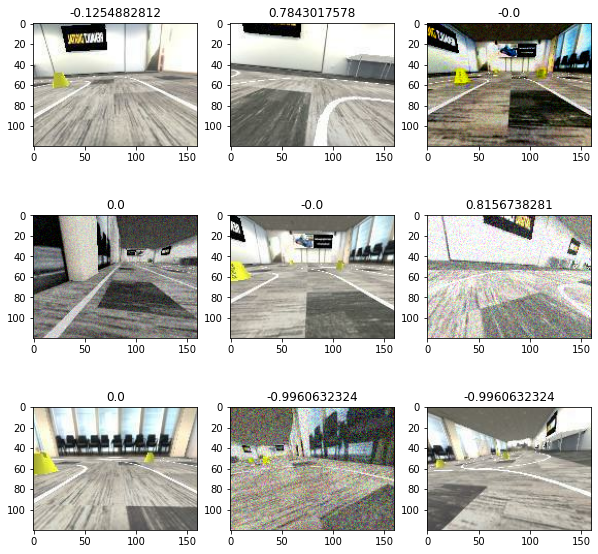

In [55]:
plt.figure(figsize=(10, 10))
for i, o in train_tensor.take(1):
  img = DonkeyCarDataAugmentator.unnormalize(i['image'].numpy())
  for k in range(9):
    ax = plt.subplot(3, 3, k + 1)
    plt.imshow(img[k].astype("uint8"))
    plt.title(str(o['angle'][k].numpy()))

## L'entraînement

Pour ré-entrainer un modèle, **relancer toutes les cellules de code** sinon TensorBoad risque de mélanger les metrics avec l'ancien entraînement !

### La configuration de l'entraînement

In [56]:
INITIAL_EPOQUE = 0
NBR_EPOQUES = 10
NBR_EPOQUES_APRES_EARLY_STOPPING = 4
STEPS_PER_EPOCH = int(NBR_ROW_TRAIN_SET / BATCH_SIZE)
NUMBER_EPOCH_CHECKPOINT = 10

logger.info(build_log_tag("[TRAIN CONFIGURATION]", INITIAL_EPOQUE=INITIAL_EPOQUE, 
                                     NBR_EPOQUES=NBR_EPOQUES, 
                                     NBR_EPOQUES_APRES_EARLY_STOPPING=NBR_EPOQUES_APRES_EARLY_STOPPING, 
                                     STEPS_PER_EPOCH=STEPS_PER_EPOCH, 
                                     NUMBER_EPOCH_CHECKPOINT=NUMBER_EPOCH_CHECKPOINT
                                     ))

2021-08-25 14:19:19.769 | INFO     | __main__:<module>:7 - [[TRAIN CONFIGURATION]][INITIAL_EPOQUE="0"][NBR_EPOQUES="1"][NBR_EPOQUES_APRES_EARLY_STOPPING="4"][STEPS_PER_EPOCH="141"][NUMBER_EPOCH_CHECKPOINT="10"]


### Callback

In [57]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=NBR_EPOQUES_APRES_EARLY_STOPPING, restore_best_weights=True)

In [58]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_FILEPATH,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    save_freq= NUMBER_EPOCH_CHECKPOINT * STEPS_PER_EPOCH
                                    )

In [59]:
log_dir = get_new_tensorlog_path()
histogram_freq = 1
profile_batch = '500,520'
logger.info(build_log_tag("TENSORBOARD", log_dir=log_dir, histogram_freq=histogram_freq, profile_batch=profile_batch))
tensorboad_cb = keras.callbacks.TensorBoard(log_dir=log_dir, 
                                    histogram_freq=histogram_freq,
                                    profile_batch=profile_batch)

2021-08-25 14:19:26.793 | INFO     | __main__:get_new_tensorlog_path:5 - [LOG_PATH="/home/nigiva/git/donkey-car-trainer/data/log/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629893559.0173726/20210825-141926"]
2021-08-25 14:19:26.795 | INFO     | __main__:<module>:4 - [TENSORBOARD][log_dir="/home/nigiva/git/donkey-car-trainer/data/log/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629893559.0173726/20210825-141926"][histogram_freq="1"][profile_batch="500,520"]
2021-08-25 14:19:26.805264: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-08-25 14:19:26.807101: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-08-25 14:19:26.815198: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-08-25 14:19:26.848525: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object 

In [60]:
cb = []
cb.append(tensorboad_cb)

logger.info(build_log_tag("CALLBACK", cb=cb))

### Lancer l'entraînement

In [61]:
# Entraîner le modèle
with tf.device(TRAIN_GPU):
    brain.model.fit(train_tensor,
              validation_data = test_tensor,
              epochs = NBR_EPOQUES,
              initial_epoch = INITIAL_EPOQUE,
              callbacks=cb)

2021-08-25 14:19:40.978199: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 24192000 exceeds 10% of free system memory.
2021-08-25 14:19:40.978737: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 24192000 exceeds 10% of free system memory.
2021-08-25 14:19:41.091140: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23328000 exceeds 10% of free system memory.
2021-08-25 14:19:41.091599: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 23328000 exceeds 10% of free system memory.
2021-08-25 14:19:41.173706: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 27000000 exceeds 10% of free system memory.
282/282 [==============================] - 283s 969ms/step - loss: 0.2659 - mse: 0.2659


### Sauvegarde

In [38]:
brain.save(SAVE_PATH)

2021-08-24 21:24:42.419595: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
INFO:tensorflow:Assets written to: /home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629832897.3134723/model.tf/assets


#### Convertir la sauvegarde en archive

In [ ]:
!tar -czvf $MODEL_NAME_TAR $SAVE_PATH

## Évaluater les performances


### Avec le jeu de validation

In [40]:
performances = brain.model.evaluate(validation_tensor, batch_size = BATCH_SIZE)
logger.info(build_log_tag("EVALUATION", performances=performances))

8/8 [==============================] - 0s 51ms/step - loss: 0.0425 - mse: 0.0425
2021-08-24 21:25:05.352 | INFO     | __main__:<module>:2 - [EVALUATION][performances="[0.042484648525714874, 0.042484648525714874]"]


### Avec TensorBoard

In [89]:
print(MODEL_NAME)
print(os.environ["LOG_PATH"])

DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629812869.419665
/home/nigiva/git/donkey-car-trainer/data/log/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629812869.419665/20210824-155640


```
!python3.9 -m tensorboard.main dev upload --logdir LOG_PATH \
  --name MODEL_NAME \
  --description "Donkey Car Train by ESLR Lab (EPITA)" \
  --one_shot
```

In [ ]:
!python3.9 -m tensorboard.main dev upload --logdir $LOG_PATH \
  --name $MODEL_NAME \
  --description "Donkey Car Train by ESLR Lab (EPITA)" \
  --one_shot

## Tester le modèle en production

In [ ]:
raw_request = """{"steering_angle":0.0,"throttle":0.6,"speed":1.41243,"hit":"none","time":192.1153,"accel_x":-0.0621737,"accel_y":-0.6418809,"accel_z":1.450789,"gyro_x":-0.0005175234,"gyro_y":0.0000451516,"gyro_z":0.0001938246,"gyro_w":1.0,"pos_x":-64.98518,"pos_y":0.573791,"pos_z":-3.576344,"vel_x":-0.006629555,"vel_y":0.292744,"vel_z":1.381743,"cte":0.02104999,"activeNode":2,"totalNodes":114,"on_road":0,"progress_on_shortest_path":0,"user_angle":0.0,"user_throttle":0.6,"user_brake":0,"label":"E","msg_type":"telemetry","image":"\/9j\/4AAQSkZJRgABAQAAAQABAAD\/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL\/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL\/wAARCAB4AKADASIAAhEBAxEB\/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL\/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6\/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL\/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6\/9oADAMBAAIRAxEAPwDEiuZoAQjnaeCD0qspeKQSRsUYHIIOMVJ355qwLRpI98J3juvcUhnd+EfiJNEostYBmhXAEv8AEv19a19e8Hw655ep6BPCu9tzouArH1HofUV5Xbjy7gBgQTxg1raN4l1Hw\/eeZazExk\/PExyrVLXYpM14UuLPUHt79Ns8MgV0PTORz7gitW8vjba5KFlEIazjCOf4cdD+BAq1qd9p\/iiz+12+2DVIItzwseZUH931x19a5zxDE1zJZ3COFAiO4+2R\/jS6Ck2dvFr0Wq6TauhO+MKH9AfmUj\/x3P4iupDCfQyRyGtyP\/Ha8b8KTNFLe25YHABwD6HH9a9a0CYTaLHGTkncoH4mnHcT2Of0nS2eLm6mT\/ZXGBxWnc6IosZZVupyyrkAml0Zd6OwXgHHT2xWzMuLCcEf8s27e1btLlME3zWOShsGMas00nJP8VWo9M34Hmy8\/wC1WpbwE2ysFUjnqvTn1qxCvI4H5VSSsTKTuc1faX5N2iLNKQUDHLe9LFY7uDLMPo9a+oJuvmPHEaj9aRI8J0FKKTHKTVjMfTY2hdjPcjapP+trKgs2KhjPcZJ7SkV0t2AtlMeny4\/OqEEeFUY7Ciy5rCUny3IIbEHGZ7rn\/pu1XW0fzLq2hjmnwwLybpCcLn\/9dWbeM+hrXtYiLmWQgfKqxqfwyf1NKaSRUG2xItItYgAN5+rVIdPtyMbW\/wC+jVoEHpQTg1lZGx4LNp0Eoy0eD6jiqq2ElrLvgfI7q3etQMxXIPPoaRm7kVnc1aRWMCTKPMjH49RXNaij2d7JFnKn5lz711oYbcYrB8RQ\/wCpuAP9hv5j+tVFkyQWzu6WUynD4Mec\/h\/StyzZgpgnDcdAfQ9a5yzcnS9w6xSg\/wCfzrchv5LkLCYwZOoIHJp9CRbHFp4jkhX+KEAkDAPyg\/0rsfDuvr\/ZMdvISs7XBhUjjnJIriInP\/CRwls5aJgc+oBqlJeT2d\/KI227JhMnsR3\/AFpLcHse2eHnAs7hcD5ZCePrWvcMGsJmHQxsf0rkPDl215GskfG5VJwe5UH+tdTKfL0a4zj5Yn\/ka2kvduYr4iSwAbT4+OoP8zRbxgOxrJsNZVLaKEpk9m7Af5zWrBOpJ6URT5RTauU51D6lMp6AL\/IVIYxjGBVQzhtUuSMH5gP0rQD5x8o\/WqhexM9yhrAVLEAYy7Af1qhbKpJ47+lWtbmVprOHjLSZI\/L\/ABqS3hAdAI1wRzxTj8TE\/hRqWsCCJPlGcelSW4Hk7wPvkv8Amf8ACo5X8q3dgQpCnBx36D9asouyNU\/ugCs5PU1prQkqtdzfZ7WSTPKrx9e1WawfEd+lvbrAWAZzk\/Skld2Kk7K55L8zDgj8aersF+cAiqokkzx0oMj456ViblwPERzkfSqupwJcafKitk43KMdxUYk96R59q80AYumfvLa8g7mPcPwrY09JjbLexbTtUkg+1UdNtHj1BpgP3DZU47Z5q1Z3otIXt5CuEQ4HTOO31qmyUhkdyZ9dt5sAZbBH1FQ6yhF5v9Vq\/KkalJFRQykEEdaz9SuluJSuwqRz1pJ6g1oWND8YX2jXVxaI+UktHaLgZWRQcHnr0HHsKpW3xQ8RbpEvL9rmCSJ42jKqo+ZSAeB2ODTbLRbXUZY5X1iPTrhZPKDuQBtI5PUetP1HwRp8Hh9NQj8RWc9z9424wpA9OvWtruxlZXHRfEnU7eRQiW5jXjlTkjPrmtnWvijqdjqRh05rdoPLVg7IWJJGc9feuNh8PwXWnJOdTt4nfrGV5HX39q2bbwlZ39kbq61+3VlgXC4BbhBhev0FNN2E0rkWp\/ETVbuOF7e5e2lYsZjGANxzx\/n3rXh+JN1D4Ie3W9lOrFv9cRuKqX6knocZFYnh\/wAIJrN3eQx3\/lRwAuAqhiy5x\/Vfzq5D4O0mK9+z3XiBbVm+9vjLHqxBOOOgX86zjVjzumnr2CSW7IdC8c3qauLzVry4uY4Y2O0nJ6dh9cflTtE+IWpw+JLa61HUrprFZC8kYbgjB4x+VNg0nRbPX9QtZNZD24iSGO5MR6yEBiAB2UtU+q+FvCtqLRbTxQ9w006xyH7PtEaHgt056itE2FkbWh\/EnW9c8YWllJOv2CS4y0aQjPlglsevQV7ixKsvIC9D657V4z4b8M6LY+N9MGla49xtzLu8oICR\/BnryoY16wdTt4rhkLyNnpgZUfjUsqKLsvyx7xtBXnJGcetfNnxF8SXuv+N1sLGWQp5gijVGIyxOP8K9v8SeILa10S4mSVlkVSFUkDcSOP1ryfwr4c02bxba3X22S4uImM7q7jaMcDAHuQefSk3ZNjtdpEPmkfxGgyn1rPaRu7U0yHjsD0zxWVjQvmZR1I\/Oq7y7j14qr5ucctz12jpVmO5sIwDJDLIw6gvx+Q\/xp2Fckt7x7acOo3A8Mp6MKdeaLezztcWcLNHOd3zHaQD2IP8ASr1p4gsrcBo7AjjBIwP\/ANdbGlatd6vd+RpunTzyYyxQABPqTwPxIos0F0VYtBu3ijM7ZH8SrkZHscf0qS08LXbt5q2drLsPMtwXCL9c4XH1rqftdpYhUkc31ycjZC+IQeercFux4AFZ95f3d7IfNbEQOBGvCr7ADgUbBuNgtdMtoxG9pBNNzuMSlY168r3PY84+lWl8mONV+zgDOQNgzz+GaoFo4kCbWLL1x6+lOZ5sDMbEbugGcc4oCxphrU5\/cp6HJAP8qfFa2TH95ZwsrDPmbuV+gyAfof0oMFtFbJIEAfgkmlSKCWX\/AFabWAPJ4xSuBBLaalbpL9ifTZLd+rKjiRV91zwOmeo6c1Fax3CERzJaOo\/iCvn+VXzH9juVaAyRSAZQqfzwf6VeWSCdwkzG2c8CSMDafqvTt2x+NZqlTU3US1fUDHlS0MuJLeDHT5Qw\/HmrkEGnYchQqn7mRv8AoOcVR1WS\/wBPVpWtZbq1H\/LaEhkXp15yp5HBArGTxda7Su2UN24C\/wBa11FdHUeTblT5T2vJ+61vz+fH86rXOm3DS7YYLGR\/7qROc9+qs3b+Vc+3i1IzlYbll9VAz\/OhPGFvIcB5oyf+eij+eaNQ0Nc+fEAPsNuT3xcuB37GP6d+x9eJlMLwgzQiOXdgqqlxj1ySOfbH41Fa61LNFsh1OBkY8xmQrj8wM1fE96uyR1t3UcAFdoP4rgn60hnk52ofvAEHPyjkVNDp89wwKwlAf4m4zW5b6bDC6iIMZD0YqCR+H\/6quw6I1zOUXz53frGp6\/XHP603JIulSdSVrperscjc2X2clXlUsOoBzinabpV3q1yttYWklzMeoUcKM4yT0A56mvQoPCARwl9BaWqAD7yrIxGDyAM+nUkfjTNXtjp01tBobanLAsm+WOK9S1gIIAOdgEh6D6AHHU0Rm3urFVqMKeimpPy\/zK+m+AbS0Cz65c+dIuD9jtm+UH0d\/qCCB+dbc03+jLZ2sKW9mOkMQ2RjpyfXpnnNat4NP1DQXhacwXCoPMFmFWQnH3UaVe\/97g98is7wasiWkkGpadFFDG5Zbi8vluZZXJ+mAAPTH05JpvUxRWIitpVjjTdLIOO5P19B7U\/+zYI4i7DMrHlzySfaqmoRp4f8Rpd2UF7rbzKxdZr2OKBGYgDChcHuMYwMjv02PEWkWmqQpINWkspra3Lmz06RMux\/AFuRgZA\/DJpcoXMaS2Q7ygwq4Ue\/+fWprG22p8wJJPH0HA\/z71Z0XU21uzubSfSk0JUiCw3EsyyuSfTcoycDliT2qvdalc+D1Syh0258RmXMpuAAPKHQJ8qMOxP40coXIby6RTJbOxB2ntnAquZjH8ySHOAw\/wA\/56itl9Hin1OPWDqtogZFlOlywxY+7zGWPI54zjj0rKt9WTxaGsl05fDTQjzRdvAkisBwU+ZVA9ev8NPlDmG\/b2dQhkPlyd\/7p\/zxUkN9MheK4PmnqQRg49R6\/wA6tX1\/B4a0uytE0u18QuysktxbKiPntuVVbHBAznnFSeHLKAbb+XWbS7imiJWxvbWOOSI9gW6gjoTtwRzjpRyhcrQ6rd204a3mbGOOQSPYjoRUUmnaDrRZLq1i028bpLEmInOe69uPcdSSahn1CTV9cS0WKXw8UYoZTZxXNvIwPHzYGM+uSD7d+g8QXdlp2jh49Ptb1goEklgsO9G\/vLG4bj2+bH600hM891nwpqGkgPk\/Zn5S4jYtEwPTkdPxrnZ450P7z5l7MD\/WvZfAqy3OlzSy332qF2ZXhlsPs7RscZUgNsIx6L368YHMa1ptnDrkln\/Y99Csm6TKxl4D1wV8voDgAZAx3xSlorl04KcrNpep58JjGQY3PuDx+tXbXWru2IEdzKh9AxrfvfDdow2gSW0oAPOT1wRkH2rOHhWXLL9riCc4LqSP\/rVnGpFnTWwNekua113R6PaeGlt4vP1KZbSL\/nmhBduvU88\/nkelWJ9XgsYWTT4RbRnguRl3\/wA89cn0xWNeazJLIzs5llxhnY8L7D\/AVQVZLjDSuzDJIXHH+f0q79jlsXhdzXUnyby7HJYnk0kYwWWCTdIPvTMOF+nr9elIquyRwRoSpOWUNy31PpVoNFGipuDshAbaPlz2A9T+lSMkggEmU52kZJbq3\/6\/zP0qzPKsEC5UDbwijHWmhzHCJZmC5\/hB4P8A9b1NZ7q97ciOOcsW7A\/dXuT\/AEoEMtB52pNdXEnyxqSuTwzDqeew6D6mrsuLeJ5gx8yT52bPO0dvb\/E09vIllFlGAYrcBn56nsP61BfNvdIB97IaTHoP\/r4\/WgEMgk8+5+dQAmCRjv1I\/wA\/3q0w+wKCMsT1FULSNEiBPys\/Jx\/n0xT57gJA8qtIvlMqnHfkZxn2oGVrvDyIwOCQ4H1wT\/SlC4cEL8rE859QCOKcyfMhbllztJPv\/hVBSVmnjJYpE6MhH8Kkf41ViSnbbLS5ls5AVbd8m0cEY+Ug\/Tjn+7Vi6gUD7RFIyuv3tvVW6gj2P9frTmjhuNSBki3bgNpAIwQc1du7NVhk8k7BKuFbsp6\/lQMzbefdHuf5kPEi46D1Ht2Pp9Ksh0t5FDM3kn7smfuH0b296rWMRWQSSq6Pn58HBU+o\/D8x9K2kt4HjeMopyMMB\/EKTApy2QdGeBFZiOQDwR3xVQRzgKEzx\/CTyP90\/0NTr52mPgEtb7uO5Qf4e9aDxLcoJUYbjgEgcH60AJp\/iK6tI\/JuVNxakbSrjpxjHt\/L2HWr1xoul68jTafN5Fx97y2OPx+n5iseRMHbNuRl+649PcdxUH2aVLgeRN9nlB3LhvlY+oPY\/hTTCxH5ZVUZwqg\/dUf5\/z3Paljwz4DBiB1zwKhiBkDt5mePmY9APQUed\/wAskX92TwB1c+ppDLQvDGGghyc8NJ3PsP8APFWoUjtI\/NdhjueoHsPX+tU0IjRnwjMBzjooqjJdpd7mZ2W3i7jq309z+lIC5dai0j+bIf3YOEQDgn0+n+e1amnwm3tC2R59wc56muXs4ZdU1Abl2W8Y5HZF9K6uHLDeMAsNqD+6tOwkPto4rUkRYOSS7Hqx96zGvln+1SBiGkcQqAe3r\/OrGoXAgsLhgoRsYXjknoKxrW2ZZ7eNMkopd8+poSA25ZlgkjWPASNfmz3GP0qi03maVhlwzvuPOc81Xv7x4rS4LAAY2gjuTxVe5na3sosMF+4N3XnP\/wBeiwzoiVMqL0Oxjx15PFZBBj1KSLaw8235JOQSOB\/KrjXDNJBgAExnBx35qhffu9TgkVwHIYFcfQ\/400SWovNLb2XBBxt9PStlYhNbhMckcHofoayWmQ3W3ayb1GTjqa1bWbEhiIOT8wOKTGZOpW+yMSqypMuFYMOGHY03Tr0yKyoN00ZwEJwT6rn19K1tQtYbiPcy5JPIrlb5Psd2JoiWCjcQMgsPX6imhHTsI7qJXU8diRyp7g1moJdPmPAEWclM8D3HtVix1CO6tTdQYdGP74L1H+1j+dWLmP8AdBkw6EZBFIZJvW5iDgbl9utVGtF\/gUSRkYMbcfl6fTpVUpPpqrcxEtET8yjkL+HpWlBcJdw+cgwD1AOeaAMGWRZZVtoUDMOdv8I9zUkduy73Zt5PWTt9AKKKGNGY8sl7ctaQMVi\/jYc0bCZlhh3MBwijp7k0UU0JnQ28Sqn2ZAAq8ykDr7VKLoRBpCAAeFGO1FFAGBqt6Lu8ggYnAHmPtNFhMQsszN8znj2AoooAo3twdqRDq0gIB5yRzT7ydfsw3jcfMXGT3zRRQBopMyNDuZvm6e1Mu223EbOQdrg7jz14\/rRRQIstcEom0\/cPU+1XJLgCEXC7i8fzfL3oooGasVzFeWqyKRh1BGapTQidM7VVozw\/UY9KKKQFKwsItOuJJkkZMt86dVFamyW1O6IJJbMfu+mfT\/CiimBXntjDMZ42cwycPGOx+lR\/YGjYyWkhQkZK4xn\/ABoopAf\/2Q=="}"""

request_dict = json.loads(raw_request)
request_dict

In [45]:
brain = DCModelWrapper.load("/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629812869.419665")

2021-08-25 15:05:18.114 | INFO     | dctrainer.model.model_wrapper:load:30 - [LOAD WRAPPER AND MODEL][path="/home/nigiva/git/donkey-car-trainer/data/model/DCDeepModelV5.0-reda-renault-speed_accel_gyro-1629812869.419665"]


In [46]:
brain.predict(request_dict)

it <TensorSliceDataset shapes: {image: (1, 120, 160, 3), speed_accel_gyro: (1, 7)}, types: {image: tf.float32, speed_accel_gyro: tf.float64}>
pi <ParallelMapDataset shapes: ({image: (1, 120, 160, 3), speed_accel_gyro: (1, 7)},), types: ({image: tf.float32, speed_accel_gyro: tf.float64},)>


(-0.37521997, 0.2247800290584564, 0)